# Model 1

This notebook simulates population age distributions using model 1 (where agents survive according to an age-specific surivival probability). Model 1 is suitable for age distributions where the fraction of the population within an age group decreases monotonically with age.

## Import packages

In [1]:
#Load in required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os, warnings

warnings.simplefilter("ignore")

## Define necesssary functions

In [2]:
def p_n_min_getter(target_dist): # Calculate minimum possible value of p_n (surivival probability in oldest age class)
    
    p_n_min = 1 - (target_dist[(n_groups-1)-1]/target_dist[n_groups-1]) 
    
    return p_n_min

def analytic_solver(target_dist, p_n): # Calculate surivival probabilities for given target_dist (age distribution we want to generate from our simulation) and p_n
    
    survival_probs_analytical = np.zeros(n_groups)
    
    for group in range(n_groups-2):
        survival_probs_analytical[group] = target_dist[group+1]/target_dist[group]
        
    survival_probs_analytical[(n_groups-1)-1] = (1-p_n)*(target_dist[(n_groups-1)]/target_dist[(n_groups-1)-1])
    
    survival_probs_analytical[-1]=p_n
    
    return survival_probs_analytical
    
def obj_func(survive_probas): # Run simulation
    
    ages = np.random.randint(0, n_groups, size=pop_size).astype(int)
    ages_history = np.zeros((n_groups, max_itera))
    
    for itera in range(max_itera):
        
        trials = np.random.rand(pop_size)
        survival_probabilities = survive_probas[ages]
        survivals = trials <= survival_probabilities
        deaths = trials > survival_probabilities
        ages[survivals] += 1
        ages[ages==n_groups] -= 1
        ages[deaths] = 0
        
        uages, freqs = np.unique(ages, return_counts=True)
        ages_history[uages, itera] = freqs
        

        if itera == max_itera-1:
            
            plt.figure(0, figsize=(6,4))
            
            for i in range(n_groups):
                plt.plot(ages_history[i,:], color = palette[i])
            plt.xlabel("Timestep")
            plt.ylabel("# of individuals in age group")
            plt.xlim([0,max_itera-1])
            plt.title(f"Population: {df.iloc[numselect,3]}")
            
            plt.tight_layout()
            plt.savefig(f'{home}data/results/timeseries_{df.iloc[numselect,3]}_model1.png', bbox_inches="tight", dpi=500)
            plt.show()


    ages_final = ages_history[:,-100::].mean(axis=1)
    ages_dist_noncum = ages_final/ages_final.sum()
    
    return (np.mean(np.abs(ages_dist_noncum - target_dist_noncum)), ages_dist_noncum) # Return mean absolute error in age distribution, and the simulated distribution

## Read in necessary data

In [3]:
# Set working directory
home =  os.getcwd()[:-4]

# Read in monotic decreasing (md) age distributions, as model 1 is appropriate for these
df = pd.read_csv(f'{home}data/required/agedists_countries2019_md.csv')

## Set simulation parameters

In [4]:
pop_size = 10000 # Set number of agents within a simulation
max_itera = 350 # Set total number of timesteps in simulation

# Select age distribution to simulate
numselect=36 # Select index of the age distribution you want to simulate (numselect=36 returns Eygpt's age distribution)
target_dist_full = df.iloc[numselect, -22:-1]
target_dist = target_dist_full[target_dist_full>0].copy() #Drop all age classes containing zero individuals (can be absorbed into a neighbouring class)
n_groups = len(target_dist) # Set number of groups to match the number of age classes in the data
target_dist_noncum = target_dist/target_dist.sum() # Calculate age distribution from counts of individuals in eage age class
target_dist_cum = np.cumsum(target_dist/target_dist.sum()) # Calcualte cumulative age distribution from counts of individuals in each age class

# generate colour palette for timeseries plot based on n_groups
palette = sns.color_palette("flare", n_groups)

## Find minimum p_n value
p_n_min = p_n_min_getter(target_dist)

if p_n_min <0:
    p_n_min = 0 #If min p_n <0 set =0 since probabilties cannot be <0

# Generate a random p_n value no smaller than our minimum possible p_n value
p_n = np.random.rand()*(1-p_n_min) + p_n_min

# Generate the corresponding p_i values for i=1,...,n-1
analytical_survival_probs = analytic_solver(target_dist, p_n)

## Run a simulation

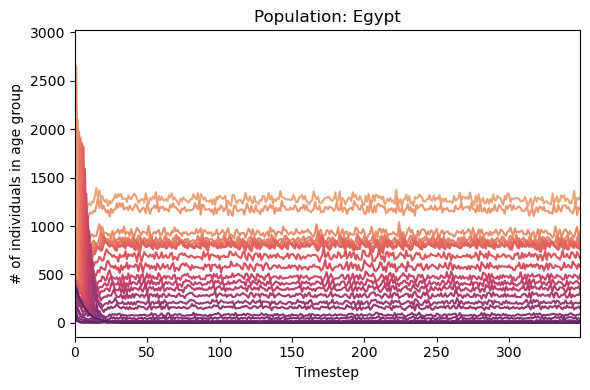

Mean absolute error in P(age group == i) is: 5.860276476885985e-05


In [5]:
# Run a simulation with the previously calculated survival probabilities
sim_output = obj_func(analytical_survival_probs)
numerical_dist_noncum = sim_output[1]
print(f"Mean absolute error in P(age group == i) is: {sim_output[0]}")

## Plot results

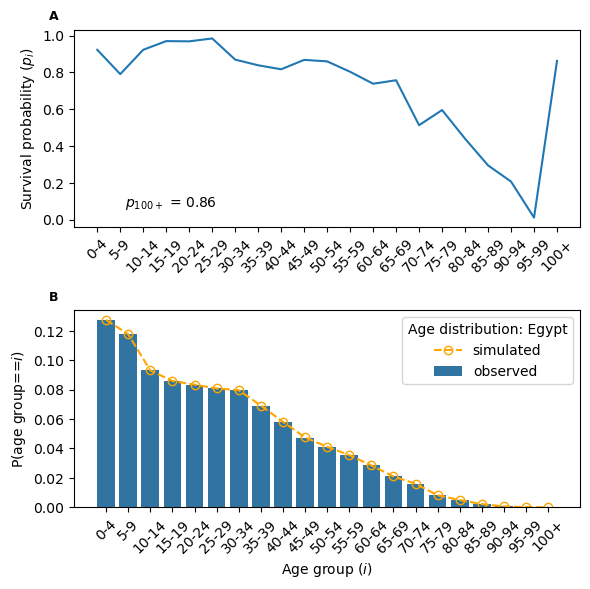

In [9]:
# Plotting parameters
cap = [ "A", "B", "C"]
palette = sns.color_palette("flare", n_groups)
subcap_x = -0.05
subcap_y = 1.05

dpi_val = 100

# Generate plot of calculated survivial probabilities and resulting fit to the observed age distribution
plt.figure(0, figsize=(600/dpi_val, 600/dpi_val), dpi=dpi_val)

plt.subplot(211)
ax1=sns.lineplot(x=target_dist.index, y = analytical_survival_probs)
ax1.text(subcap_x, subcap_y, cap[0], transform=ax1.transAxes, size=9, weight='bold')
ax1.text(0.1, 0.1, r"$p_{100+}$ = %.2f" % p_n, transform=ax1.transAxes) 
plt.xticks(rotation=45)
plt.ylabel(r"Survival probability ($p_i$)")

plt.subplot(212)
ax2=sns.barplot(x=target_dist.index, y=target_dist_noncum, label = "observed", color = '#1f77b4')
ax2.text(subcap_x, subcap_y, cap[1], transform=ax2.transAxes, size=9, weight='bold')  
plt.plot(numerical_dist_noncum, "o--", color="orange", markerfacecolor='none', label = "simulated")
plt.legend(title=f"Age distribution: {df.iloc[numselect,3]}")
plt.xticks(rotation=45)
plt.xlabel(r"Age group ($i$)")
plt.ylabel(r"P(age group==$i$)")

plt.tight_layout()
plt.savefig(f'{home}data/results/agedist_{df.iloc[numselect,3]}_model1.png', bbox_inches="tight")
plt.show()

## Store parametrisation

Surrival probabilities will be stored in ascending age group order.

In [51]:
pd.DataFrame(analytical_survival_probs).to_csv(f'{home}data/results/survivalprobs_{df.iloc[numselect,3]}_model1.csv', index=False, header=False)